In [ ]:
import kagglehub
import librosa
import numpy as np
import os
from tqdm import tqdm 
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import librosa.display
database_path = kagglehub.dataset_download('swapnilpanda/heart-sound-database')

print('Data source import complete.')

In [2]:
for dirname, _, filenames in os.walk(database_path):
    for filename in filenames:
        print(filename)
        break

e00006.wav
a0031.wav
f0101.wav
e00811.wav


In [3]:
audio_files = {
    "healthy_train": [],
    "unhealthy_test": []
}

base_path = database_path

# Collect healthy/train files
healthy_train_path = os.path.join(base_path, "heart_sound", "train", "healthy")
if os.path.exists(healthy_train_path):
    for filename in os.listdir(healthy_train_path):
        if filename.endswith(".wav"):
            audio_files["healthy_train"].append(os.path.join(healthy_train_path, filename))

# Collect unhealthy/train files
unhealthy_train_path = os.path.join(base_path, "heart_sound", "train", "unhealthy")
if os.path.exists(unhealthy_train_path):
    for filename in os.listdir(unhealthy_train_path):
        if filename.endswith(".wav"):
            audio_files["unhealthy_test"].append(os.path.join(unhealthy_train_path, filename))

print(f"Healthy train files found: {len(audio_files['healthy_train'])}")
print(f"Unhealthy test files found: {len(audio_files['unhealthy_test'])}")

# Load and inspect one healthy/train file
if audio_files["healthy_train"]:
    first_healthy = audio_files["healthy_train"][0]
    print(f"\nLoading healthy/train file")
    y, sr = librosa.load(first_healthy, sr=None)
    print(f"Audio shape: {y.shape}, Sampling rate: {sr} Hz")
        

if audio_files["unhealthy_test"]:
    first_unhealthy = audio_files["unhealthy_test"][0]
    print(f"\nLoading unhealthy/test file")
    y, sr = librosa.load(first_unhealthy, sr=None)
    print(f"Audio shape: {y.shape}, Sampling rate: {sr} Hz")
else:
    print("No unhealthy/test files found.")


Healthy train files found: 2575
Unhealthy test files found: 665

Loading healthy/train file
Audio shape: (61920,), Sampling rate: 2000 Hz

Loading unhealthy/test file
Audio shape: (45604,), Sampling rate: 2000 Hz


Selected file: f0101.wav
Sampling rate: 2000 Hz
Number of samples: 61920
Duration: 30.96 seconds


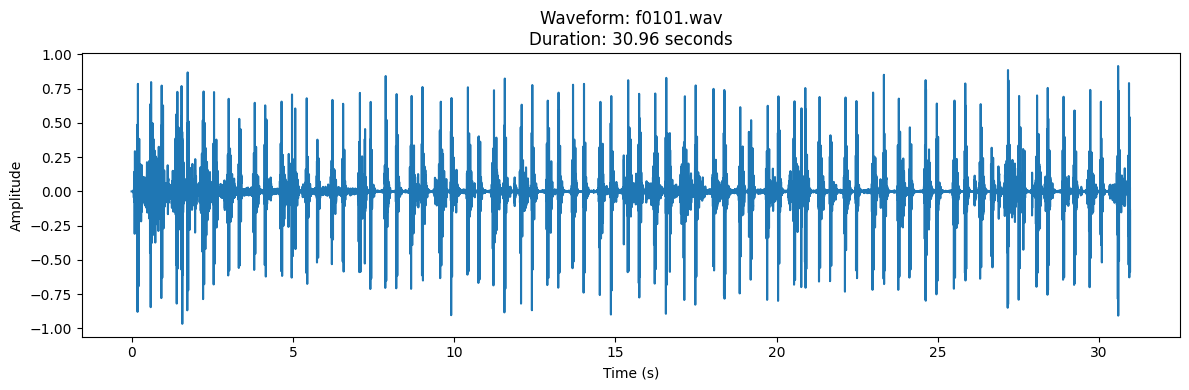

In [4]:
file_path = audio_files["healthy_train"][0]


y, sr = librosa.load(file_path, sr=None)

# Calculate duration in seconds
duration = len(y) / sr
print(f"Selected file: {os.path.basename(file_path)}")
print(f"Sampling rate: {sr} Hz")
print(f"Number of samples: {len(y)}")
print(f"Duration: {duration:.2f} seconds")

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y)) / sr, y)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Waveform: {os.path.basename(file_path)}\nDuration: {duration:.2f} seconds")
plt.tight_layout()
plt.show()


File: f0101.wav
Total duration: 30.96 seconds
Splitting into 7 chunks of 5 seconds each


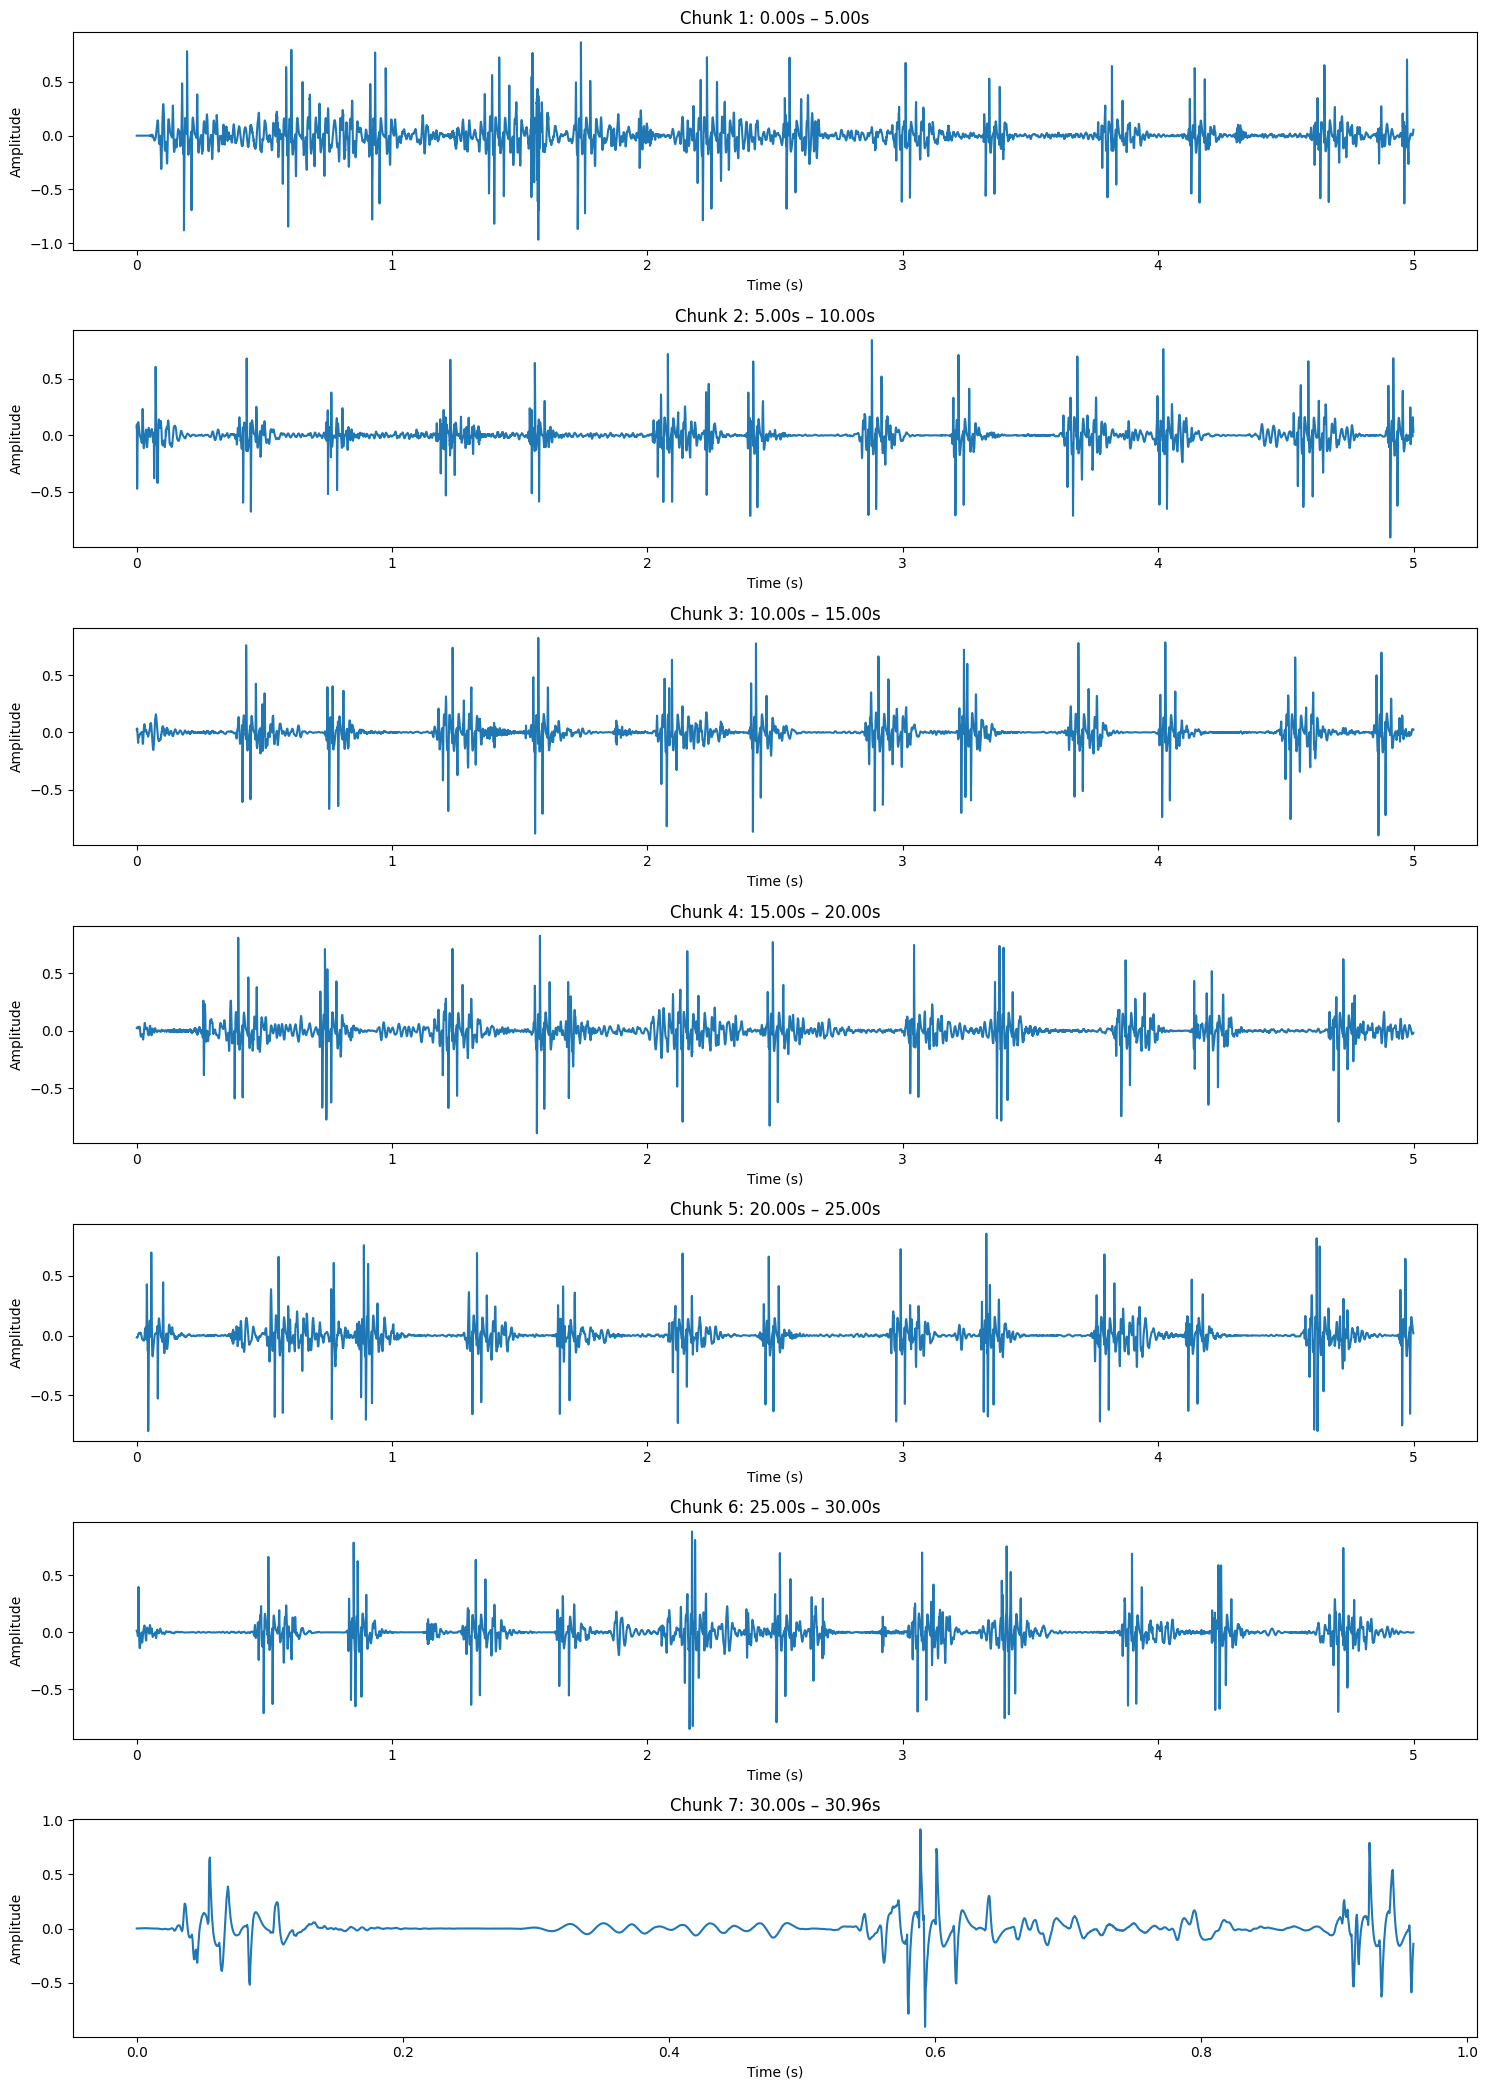

In [5]:
chunk_duration = 5
samples_per_chunk = chunk_duration * sr

num_chunks = int(np.ceil(len(y) / samples_per_chunk))
print(f"File: {os.path.basename(file_path)}")
print(f"Total duration: {len(y)/sr:.2f} seconds")
print(f"Splitting into {num_chunks} chunks of {chunk_duration} seconds each")

plt.figure(figsize=(15, 3 * num_chunks))

for i in range(num_chunks):
    start = int(i * samples_per_chunk)
    end = int(min((i + 1) * samples_per_chunk, len(y)))
    chunk = y[start:end]

    plt.subplot(num_chunks, 1, i + 1)
    plt.plot(np.arange(len(chunk)) / sr, chunk)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Chunk {i+1}: {start/sr:.2f}s – {end/sr:.2f}s")

plt.tight_layout()
plt.show()


In [6]:
def get_durations(file_list):
    durations = []
    for file_path in file_list:
        try:
            y, sr = librosa.load(file_path, sr=None)
            duration = len(y) / sr
            durations.append(duration)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.array(durations)

# Get durations for healthy/train
healthy_durations = get_durations(audio_files["healthy_train"])
unhealthy_durations = get_durations(audio_files["unhealthy_test"])

def summarize_durations(durations, label):
    print(f"\n--- {label} ---")
    if len(durations) == 0:
        print("No files found.")
        return
    unique_durations = np.unique(np.round(durations, 2))  # round for near-identical cases
    if len(unique_durations) == 1:
        print(f"All samples have the same duration: {unique_durations[0]} seconds")
    else:
        print(f"Number of files: {len(durations)}")
        print(f"Min duration: {durations.min():.2f} sec")
        print(f"Max duration: {durations.max():.2f} sec")
        print(f"Mean duration: {durations.mean():.2f} sec")
        print(f"Median duration: {np.median(durations):.2f} sec")
        print(f"Unique durations: {len(unique_durations)}")
        print(f"Some unique values: {unique_durations[:10]}{'...' if len(unique_durations)>10 else ''}")

# Summarize for healthy and unhealthy
summarize_durations(healthy_durations, "Healthy (train)")
summarize_durations(unhealthy_durations, "Unhealthy (test)")



--- Healthy (train) ---
Number of files: 2575
Min duration: 6.61 sec
Max duration: 101.67 sec
Mean duration: 21.66 sec
Median duration: 20.03 sec
Unique durations: 1530
Some unique values: [6.61 6.64 6.91 6.99 7.36 7.45 7.61 7.63 7.76 7.85]...

--- Unhealthy (test) ---
Number of files: 665
Min duration: 5.31 sec
Max duration: 122.00 sec
Mean duration: 25.57 sec
Median duration: 23.78 sec
Unique durations: 273
Some unique values: [5.31 6.33 6.85 7.28 7.73 8.   8.04 8.13 8.32 8.43]...


In [7]:
def compute_snr(y):
    """
    Compute approximate SNR of an audio signal in dB.
    """
    signal_power = np.mean(y ** 2)
    noise_power = np.var(y)  
    if noise_power == 0:
        return float("inf")
    return 10 * np.log10(signal_power / noise_power)

def analyze_snr(file_list, label):
    snr_values = []

    for file_path in tqdm(file_list, desc=f"Computing SNR for {label}"):
        try:
            y, sr = librosa.load(file_path, sr=None)
            snr = compute_snr(y)
            snr_values.append((file_path, snr))
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    snr_array = np.array([val for _, val in snr_values])
    mean_snr = np.mean(snr_array)
    std_snr = np.std(snr_array)
    min_snr = np.min(snr_array)
    max_snr = np.max(snr_array)

    print(f"\n--- {label} ---")
    print(f"Files: {len(snr_array)}")
    print(f"Min SNR: {min_snr:.2f} dB")
    print(f"Max SNR: {max_snr:.2f} dB")
    print(f"Mean SNR: {mean_snr:.2f} dB")
    print(f"Std Dev: {std_snr:.2f} dB")

    lower_bound = mean_snr - 2 * std_snr
    upper_bound = mean_snr + 2 * std_snr
    filtered = [(fp, snr) for fp, snr in snr_values if lower_bound <= snr <= upper_bound]

    print(f"Outliers removed: {len(snr_values) - len(filtered)}")
    print(f"Remaining files: {len(filtered)}")

    return filtered, snr_array

healthy_filtered, healthy_snr = analyze_snr(audio_files["healthy_train"], "Healthy (train)")
unhealthy_filtered, unhealthy_snr = analyze_snr(audio_files["unhealthy_test"], "Unhealthy (test)")

healthy_filtered_files = [fp for fp, _ in healthy_filtered]
unhealthy_filtered_files = [fp for fp, _ in unhealthy_filtered]


Computing SNR for Healthy (train): 100%|██| 2575/2575 [00:01<00:00, 1656.95it/s]



--- Healthy (train) ---
Files: 2575
Min SNR: -0.00 dB
Max SNR: 11.74 dB
Mean SNR: 0.77 dB
Std Dev: 1.77 dB
Outliers removed: 158
Remaining files: 2417


Computing SNR for Unhealthy (test): 100%|███| 665/665 [00:00<00:00, 1628.04it/s]


--- Unhealthy (test) ---
Files: 665
Min SNR: -0.00 dB
Max SNR: 11.80 dB
Mean SNR: 0.34 dB
Std Dev: 1.19 dB
Outliers removed: 24
Remaining files: 641


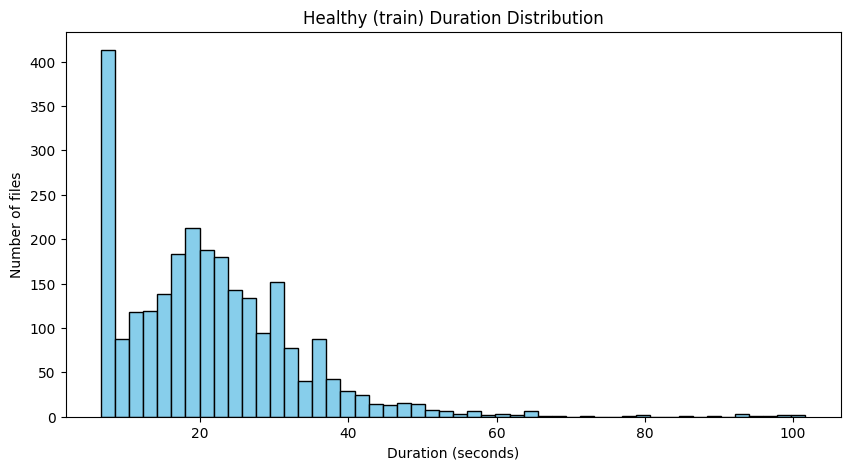

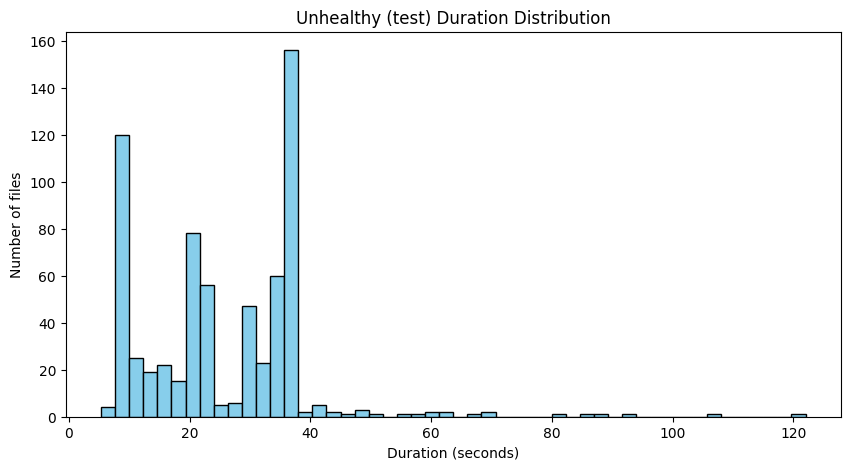

In [9]:
def plot_duration_distribution(durations, label):
    plt.figure(figsize=(10,5))
    plt.hist(durations, bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{label} Duration Distribution")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Number of files")
    plt.show()

plot_duration_distribution(healthy_durations, "Healthy (train)")
plot_duration_distribution(unhealthy_durations, "Unhealthy (test)")


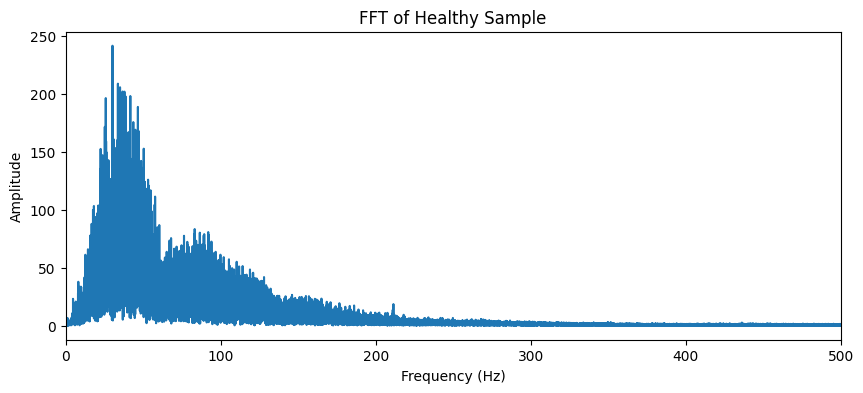

In [10]:
def plot_fft(y, sr, title="FFT of Audio"):
    N = len(y)
    yf = np.fft.fft(y)
    xf = np.fft.fftfreq(N, 1/sr)
    # Only positive frequencies
    idx = np.where(xf >= 0)
    plt.figure(figsize=(10,4))
    plt.plot(xf[idx], np.abs(yf[idx]))
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 500) 
    plt.show()

y, sr = librosa.load(healthy_filtered_files[1], sr=None)
plot_fft(y, sr, "FFT of Healthy Sample")


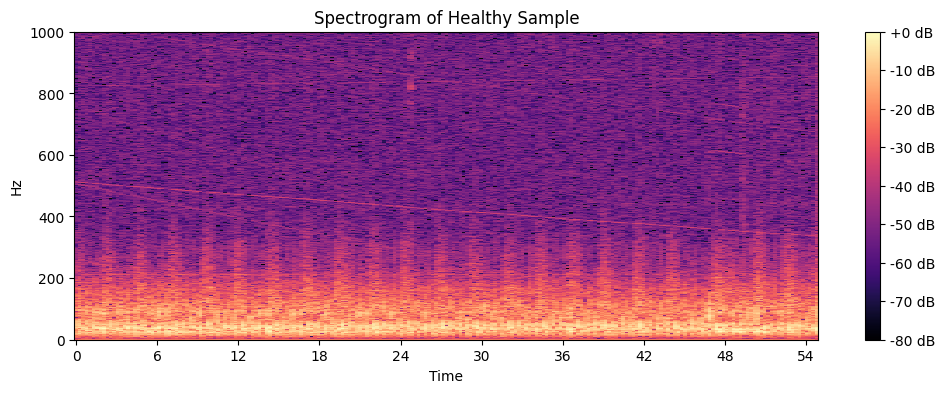

In [11]:
def plot_spectrogram(y, sr, title="Spectrogram"):
    plt.figure(figsize=(12,4))
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

plot_spectrogram(y, sr, "Spectrogram of Healthy Sample")


In [12]:
def extract_features(y, sr):
    features = {}
    features['mfcc'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    features['zcr'] = librosa.feature.zero_crossing_rate(y).mean()
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    features['rms'] = librosa.feature.rms(y=y).mean()
    return features

features_example = extract_features(y, sr)
print(features_example)


{'mfcc': array([-213.69672   ,  109.96677   ,   76.15363   ,   39.443077  ,
         18.239155  ,    7.624548  ,   -0.518682  ,    0.73326856,
         -0.6716228 ,   -0.8162398 ,   -2.1533875 ,   -2.209563  ,
         -0.40768   ], dtype=float32), 'zcr': np.float64(0.06940634084302326), 'spectral_centroid': np.float64(111.35282329844915), 'spectral_bandwidth': np.float64(158.5178303341713), 'rms': np.float32(0.050601486)}


In [13]:
def sliding_window_chunks(y, sr, window_sec=5, stride_sec=1):
    """
    Split an audio signal into overlapping sub-samples.

    Args:
        y (np.ndarray): Audio signal.
        sr (int): Sampling rate.
        window_sec (int): Duration of each chunk in seconds.
        stride_sec (int): Step size between chunks in seconds.

    Returns:
        List of np.ndarray: List of audio chunks.
    """
    window_size = int(window_sec * sr)
    stride_size = int(stride_sec * sr)
    chunks = []

    for start in range(0, len(y) - window_size + 1, stride_size):
        end = start + window_size
        chunk = y[start:end]
        chunks.append(chunk)

    return chunks

healthy_processed_audio = []
unhealthy_processed_audio = []

print("Processing Healthy (train) samples...")
for file_path in tqdm(healthy_filtered_files):
    try:
        y, sr = librosa.load(file_path, sr=None)
        chunks = sliding_window_chunks(y, sr, window_sec=5, stride_sec=1)
        healthy_processed_audio.extend(chunks)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

print("Processing Unhealthy (test) samples...")
for file_path in tqdm(unhealthy_filtered_files):
    try:
        y, sr = librosa.load(file_path, sr=None)
        chunks = sliding_window_chunks(y, sr, window_sec=5, stride_sec=1)
        unhealthy_processed_audio.extend(chunks)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

print(f"\nTotal processed healthy chunks: {len(healthy_processed_audio)}")
print(f"Total processed unhealthy chunks: {len(unhealthy_processed_audio)}")


Processing Healthy (train) samples...


100%|█████████████████████████████████████| 2417/2417 [00:01<00:00, 1682.54it/s]


Processing Unhealthy (test) samples...


100%|███████████████████████████████████████| 641/641 [00:00<00:00, 1536.83it/s]


Total processed healthy chunks: 42382
Total processed unhealthy chunks: 13934


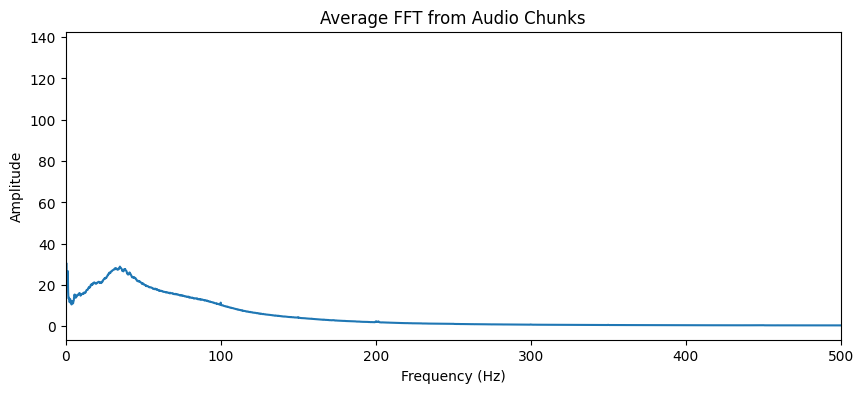

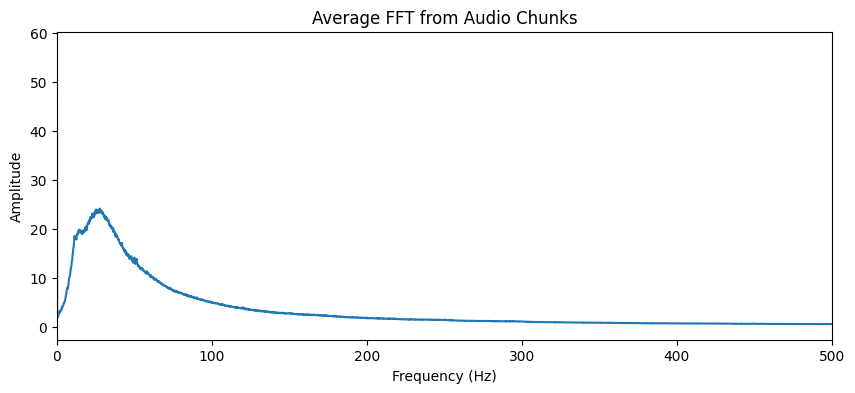

In [15]:
def average_fft_from_arrays(audio_chunks, sr=2000, N=5000):
    """
    Compute average FFT over a list of audio arrays.
    """
    fft_list = []
    for y in audio_chunks:
        yf = np.fft.fft(y)
        yf = np.abs(yf[:len(yf)//2])  # positive frequencies
        # Pad or truncate
        if len(yf) < N:
            yf = np.pad(yf, (0, N - len(yf)), mode='constant')
        else:
            yf = yf[:N]
        
        fft_list.append(yf)
    
    avg_fft = np.mean(fft_list, axis=0)
    xf = np.linspace(0, sr/2, N)
    
    plt.figure(figsize=(10,4))
    plt.plot(xf, avg_fft)
    plt.title("Average FFT from Audio Chunks")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 500)
    plt.show()

average_fft_from_arrays(healthy_processed_audio)
average_fft_from_arrays(unhealthy_processed_audio)


In [16]:

np.save("healthy_processed_audio.npy", healthy_processed_audio)
np.save("unhealthy_processed_audio.npy", unhealthy_processed_audio)

print("Audio chunks saved successfully!")


Audio chunks saved successfully!
